In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
import shap

In [2]:
# Specify the file path
file_path = 'lol_ranked_dataset/games.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path)

df

,gameId,creationTime,gameDuration,seasonId,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,...,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
0,3326086514,1504279457970,1949,9,1,2,1,1,1,1,...,5,0,0,1,1,114,67,43,16,51
1,3229566029,1497848803862,1851,9,1,1,1,1,0,1,...,2,0,0,0,0,11,67,238,51,420
2,3327363504,1504360103310,1493,9,1,2,1,1,1,2,...,2,0,0,1,0,157,238,121,57,28
3,3326856598,1504348503996,1758,9,1,1,1,1,1,1,...,0,0,0,0,0,164,18,141,40,51
4,3330080762,1504554410899,2094,9,1,2,1,1,1,1,...,3,0,0,1,0,86,11,201,122,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51485,3308904636,1503076540231,1944,9,2,1,2,2,0,2,...,10,2,0,4,0,55,-1,90,238,157
51486,3215685759,1496957179355,3304,9,2,1,1,2,2,2,...,11,7,4,4,1,157,55,119,154,105
51487,3322765040,1504029863961,2156,9,2,2,2,2,0,1,...,10,2,0,2,0,113,122,53,11,157
51488,3256675373,1499562036246,1475,9,2,2,2,2,0,2,...,11,3,0,1,0,154,39,51,90,114


In [3]:
# List of columns to remove
columns_to_remove = ['gameId', 'creationTime', 'seasonId']

# Remove the columns using drop() method with axis=1
df = df.drop(columns=columns_to_remove)

In [4]:
#Check if there are null values
df.isnull().sum()

gameDuration          0
winner                0
firstBlood            0
firstTower            0
firstInhibitor        0
firstBaron            0
firstDragon           0
firstRiftHerald       0
t1_champ1id           0
t1_champ1_sum1        0
t1_champ1_sum2        0
t1_champ2id           0
t1_champ2_sum1        0
t1_champ2_sum2        0
t1_champ3id           0
t1_champ3_sum1        0
t1_champ3_sum2        0
t1_champ4id           0
t1_champ4_sum1        0
t1_champ4_sum2        0
t1_champ5id           0
t1_champ5_sum1        0
t1_champ5_sum2        0
t1_towerKills         0
t1_inhibitorKills     0
t1_baronKills         0
t1_dragonKills        0
t1_riftHeraldKills    0
t1_ban1               0
t1_ban2               0
t1_ban3               0
t1_ban4               0
t1_ban5               0
t2_champ1id           0
t2_champ1_sum1        0
t2_champ1_sum2        0
t2_champ2id           0
t2_champ2_sum1        0
t2_champ2_sum2        0
t2_champ3id           0
t2_champ3_sum1        0
t2_champ3_sum2  

In [5]:
df.dtypes

gameDuration          int64
winner                int64
firstBlood            int64
firstTower            int64
firstInhibitor        int64
firstBaron            int64
firstDragon           int64
firstRiftHerald       int64
t1_champ1id           int64
t1_champ1_sum1        int64
t1_champ1_sum2        int64
t1_champ2id           int64
t1_champ2_sum1        int64
t1_champ2_sum2        int64
t1_champ3id           int64
t1_champ3_sum1        int64
t1_champ3_sum2        int64
t1_champ4id           int64
t1_champ4_sum1        int64
t1_champ4_sum2        int64
t1_champ5id           int64
t1_champ5_sum1        int64
t1_champ5_sum2        int64
t1_towerKills         int64
t1_inhibitorKills     int64
t1_baronKills         int64
t1_dragonKills        int64
t1_riftHeraldKills    int64
t1_ban1               int64
t1_ban2               int64
t1_ban3               int64
t1_ban4               int64
t1_ban5               int64
t2_champ1id           int64
t2_champ1_sum1        int64
t2_champ1_sum2      

In [6]:
# List comprehension to identify columns to keep as numeric
columns_to_keep_numeric = [col for col in df.columns if 'Kills' in col]

# Convert all columns to object type except columns with 'kills' in their names
df.loc[:, ~df.columns.isin(columns_to_keep_numeric)] = df.loc[:, ~df.columns.isin(columns_to_keep_numeric)].astype(str)

In [7]:
df.dtypes

gameDuration          object
winner                object
firstBlood            object
firstTower            object
firstInhibitor        object
firstBaron            object
firstDragon           object
firstRiftHerald       object
t1_champ1id           object
t1_champ1_sum1        object
t1_champ1_sum2        object
t1_champ2id           object
t1_champ2_sum1        object
t1_champ2_sum2        object
t1_champ3id           object
t1_champ3_sum1        object
t1_champ3_sum2        object
t1_champ4id           object
t1_champ4_sum1        object
t1_champ4_sum2        object
t1_champ5id           object
t1_champ5_sum1        object
t1_champ5_sum2        object
t1_towerKills          int64
t1_inhibitorKills      int64
t1_baronKills          int64
t1_dragonKills         int64
t1_riftHeraldKills     int64
t1_ban1               object
t1_ban2               object
t1_ban3               object
t1_ban4               object
t1_ban5               object
t2_champ1id           object
t2_champ1_sum1

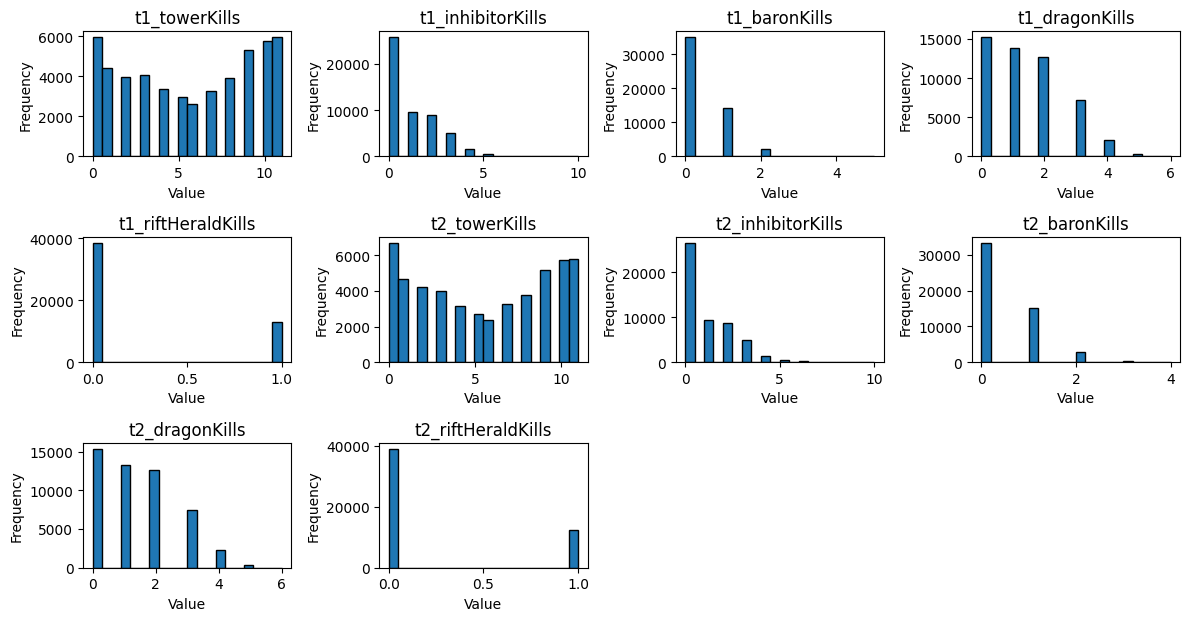

In [9]:
# Select only integer columns for analysis
integer_columns = df.select_dtypes(include=['int64'])

# Plot histograms for each column
plt.figure(figsize=(12, 10))
for i, col in enumerate(integer_columns.columns):
    plt.subplot(5, 4, i + 1)  # Adjust subplot grid as per your number of columns
    plt.hist(integer_columns[col], bins=20, edgecolor='black')
    plt.title(col)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
plt.tight_layout()
plt.show()

## Team 1 Stats

### Tower Kills
The distribution of tower kills in games shows:
- **Peak**: Most games have a high number of tower kills, reaching a maximum of 11. These high values often correspond to one-sided wins.
- **Minimum**: The lowest value is 0, indicating total defeat.
- **In-Between**: There are various games with intermediate numbers of tower kills.

### Inhibitor Kills
The distribution of inhibitor kills in games is as follows:
- **Majority**: Most games have 0 inhibitor kills.
- **Second Highest**: Values of 1 or 2 are relatively common.
- **Less Frequent**: Inhibitor kills from 3 and above are less common, with a maximum of 6.

### Baron Kills
The distribution of Baron kills in games is:
- **Most Common**: 0 Baron kills.
- **Near Half**: 1 Baron kill.
- **Maximum**: The highest observed value is 2 Baron kills.

### Dragon Kills
The distribution of dragon kills is:
- **Common Values**: 0, 1, or 2 dragon kills.
- **Less Common**: 3 or 4 dragon kills.
- **Maximum**: The highest value observed is 5 or 6 dragon kills, though these are rare.

### Herald Kills
The distribution of Herald kills shows:
- **Most Common**: 0 Herald kills.
- **Less Frequent**: Herald kills occur in approximately one-third of the games.

## Team 2 Stats
Team 2's statistics mirror those of Team 1, indicating a well-balanced dataset. In games, it's typical for the winning team to achieve more objectives, while the losing team secures fewer objectives.

In [10]:
for i, col in enumerate(integer_columns.columns):
    # Print counts of each occurrence
    value_counts = integer_columns[col].value_counts().sort_index()
    for value, count in value_counts.items():
        print(f"{col} - Value: {value}, Count: {count}")

t1_towerKills - Value: 0, Count: 5938
t1_towerKills - Value: 1, Count: 4428
t1_towerKills - Value: 2, Count: 3941
t1_towerKills - Value: 3, Count: 4041
t1_towerKills - Value: 4, Count: 3361
t1_towerKills - Value: 5, Count: 2960
t1_towerKills - Value: 6, Count: 2608
t1_towerKills - Value: 7, Count: 3269
t1_towerKills - Value: 8, Count: 3918
t1_towerKills - Value: 9, Count: 5297
t1_towerKills - Value: 10, Count: 5784
t1_towerKills - Value: 11, Count: 5945
t1_inhibitorKills - Value: 0, Count: 25732
t1_inhibitorKills - Value: 1, Count: 9567
t1_inhibitorKills - Value: 2, Count: 8879
t1_inhibitorKills - Value: 3, Count: 5104
t1_inhibitorKills - Value: 4, Count: 1584
t1_inhibitorKills - Value: 5, Count: 423
t1_inhibitorKills - Value: 6, Count: 137
t1_inhibitorKills - Value: 7, Count: 43
t1_inhibitorKills - Value: 8, Count: 11
t1_inhibitorKills - Value: 9, Count: 6
t1_inhibitorKills - Value: 10, Count: 4
t1_baronKills - Value: 0, Count: 34901
t1_baronKills - Value: 1, Count: 14179
t1_baronKill

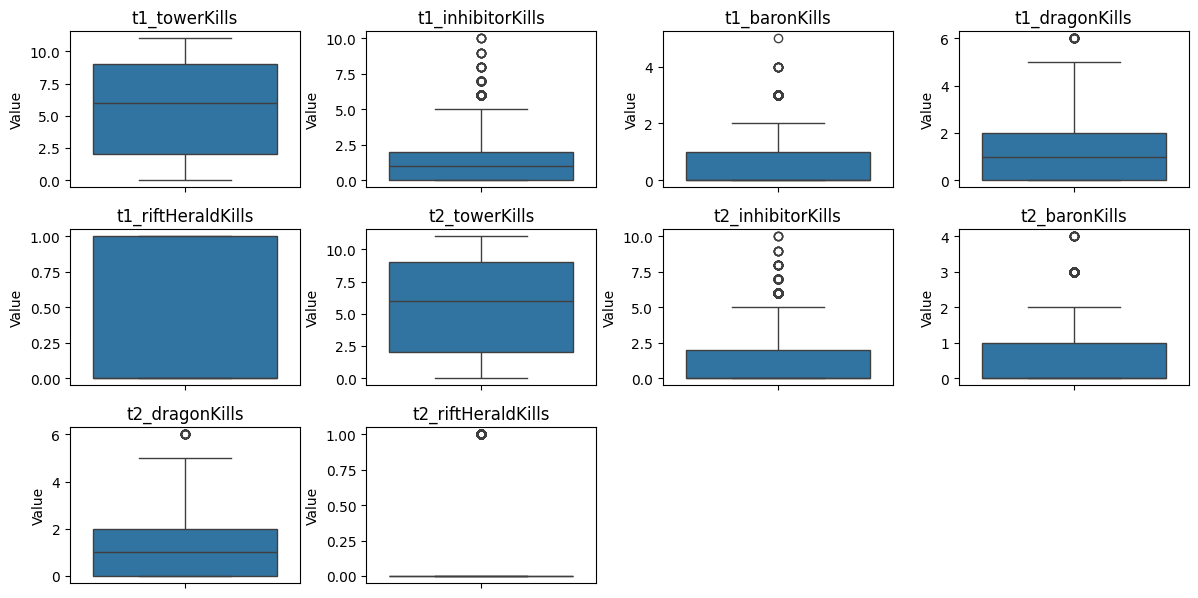

In [11]:
# Plot boxplots for each column
plt.figure(figsize=(12, 10))
for i, col in enumerate(integer_columns.columns):
    plt.subplot(5, 4, i + 1)  # Adjust subplot grid as per your number of columns
    sns.boxplot(y=integer_columns[col])
    plt.title(col)
    plt.ylabel('Value')
plt.tight_layout()
plt.show()

A box plot, also known as a box-and-whisker plot, is a graphical representation of the distribution of numerical data through their quartiles. Here's how to interpret the components of a box plot:

* **Box**: The box in the plot represents the interquartile range (IQR), which contains the middle 50% of the data. It is divided into two parts:

* **Lower quartile (Q1)**: The bottom edge of the box represents the 25th percentile of the data. It marks the point below which 25% of the data fall.

* **Upper quartile (Q3)**: The top edge of the box represents the 75th percentile of the data. It marks the point below which 75% of the data fall.

* **Median (Q2)**: A line inside the box represents the median of the data, which is the 50th percentile. It divides the data into two halves, with 50% of the data points falling below it and 50% above it.

* **Whiskers**: The whiskers extend from the edges of the box to show the range of the data outside the IQR.

* **Lower whisker**: Typically extends to 1.5 times the IQR below Q1, or the minimum value within this range if no data points are further out (outliers).

* **Upper whisker**: Extends to 1.5 times the IQR above Q3, or the maximum value within this range if no data points are further out.

* **Outliers**: Individual data points that fall outside the whiskers are shown as individual points. They are potential anomalies in the data that differ significantly from other observations.

* **Interpretation Tips**:
Central Tendency: The median and the length of the box give you an idea about the central tendency and the spread of the data.
Skewness: If the median is not in the center of the box, it indicates skewness in the data.
Range and Variability: The length of the whiskers shows the range of the data, providing insights into the variability.
Outliers: Points outside the whiskers are potential outliers that may warrant further investigation.

In [12]:
summary_stats = integer_columns.describe()
print(summary_stats)

       t1_towerKills  t1_inhibitorKills  t1_baronKills  t1_dragonKills   
count   51490.000000       51490.000000   51490.000000    51490.000000  \
mean        5.699359           1.017537       0.372286        1.387182   
std         3.799808           1.263934       0.583934        1.206818   
min         0.000000           0.000000       0.000000        0.000000   
25%         2.000000           0.000000       0.000000        0.000000   
50%         6.000000           1.000000       0.000000        1.000000   
75%         9.000000           2.000000       1.000000        2.000000   
max        11.000000          10.000000       5.000000        6.000000   

       t1_riftHeraldKills  t2_towerKills  t2_inhibitorKills  t2_baronKills   
count        51490.000000   51490.000000       51490.000000   51490.000000  \
mean             0.251466       5.549466           0.985084       0.414547   
std              0.433860       3.860989           1.256284       0.613768   
min              0.00

## Analysis of Objective Kills in Game Dataset

### Team 1 and Team 2 Objective Kills Comparison

#### t1_towerKills and t2_towerKills:

- **Similar Distributions**: Both teams exhibit similar distributions for tower kills.
- **Mean Values**: Team 1 averages around 5.7 tower kills per game, while Team 2 averages 5.5, indicating teams typically destroy about 5-6 towers per game.
- **Spread (Standard Deviation)**: Moderate spread suggests variability in tower destruction across different games.

#### t1_inhibitorKills and t2_inhibitorKills:

- **Less Common Objectives**: Inhibitor kills are less frequent compared to tower kills.
- **Mean Values**: Both teams average approximately 1.0 inhibitor kill per game.
- **Distribution**: Most games see teams securing 0 or 1 inhibitor per game, with some games reaching higher counts up to 10.

#### t1_baronKills and t2_baronKills:

- **Rare Objectives**: Baron kills are relatively rare compared to other objectives.
- **Mean Values**: Team 1 and Team 2 each average around 0.4 Baron kills per game.
- **Distribution**: Most games feature few or no Baron kills, with occasional games seeing up to 5 Baron captures.

#### t1_dragonKills and t2_dragonKills:

- **More Common than Barons**: Dragon kills occur more frequently than Baron kills.
- **Mean Values**: Both teams average approximately 1.4 Dragon kills per game.
- **Distribution**: Teams typically secure 0-2 Dragons per game, with some games achieving up to 6 Dragon kills.

#### t1_riftHeraldKills and t2_riftHeraldKills:

- **Least Common Objectives**: Rift Herald kills are the least frequent among all objectives.
- **Mean Values**: Team 1 averages about 0.3 Rift Herald kills per game, while Team 2 averages 0.2.
- **Distribution**: Most games do not include a Rift Herald kill, but when it occurs, it is usually once per game.

### Interpretation:

- **Objective Control**: Teams prioritize tower destruction, followed by Dragon kills, with Barons and Rift Heralds being less common objectives.
- **Game Dynamics**: The variability (standard deviation) in objective kills across games suggests varying levels of strategic focus on objectives.
- **Comparative Analysis**: Both teams generally have balanced access to these objectives, with slight variations observed between the two teams in some cases.

# Champion picks and bans

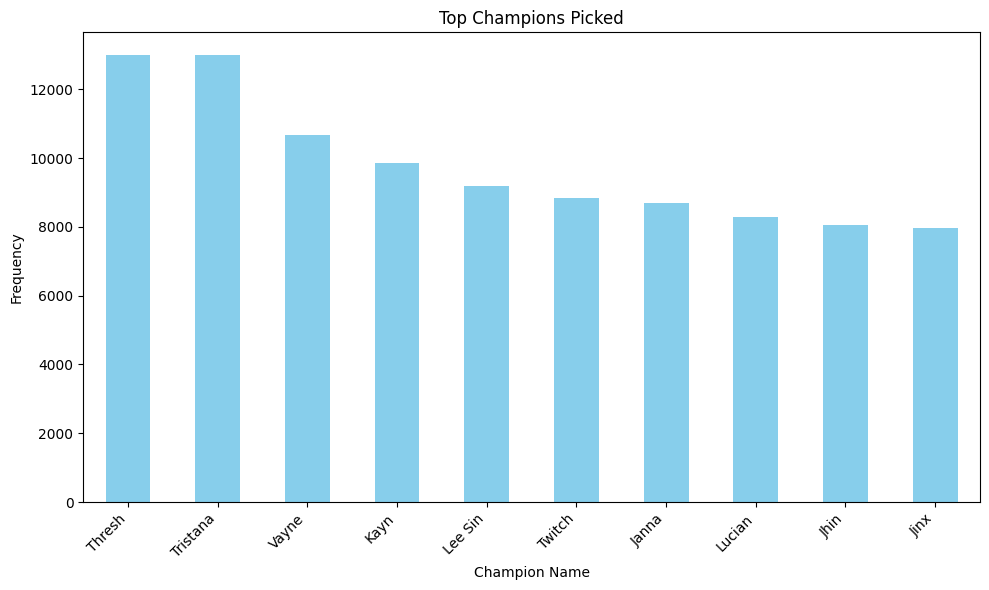

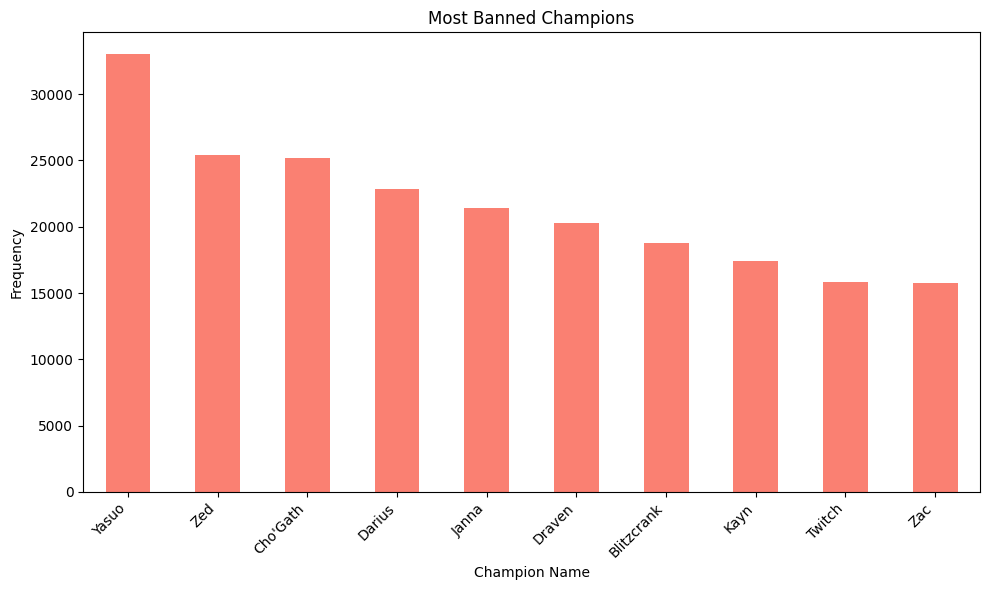

In [13]:
# Load champion information from JSON file
with open('lol_ranked_dataset/champion_info.json', 'r') as f:
    champion_info = json.load(f)
    
# Function to count occurrences and plot top champions with names
def plot_top_champions(df, plot_title, champion_info):
    # Concatenate all champion IDs from both teams
    champ_cols = ['t1_champ1id', 't1_champ2id', 't1_champ3id', 't1_champ4id', 't1_champ5id', 
                  't2_champ1id', 't2_champ2id', 't2_champ3id', 't2_champ4id', 't2_champ5id']
    all_champs = pd.concat([df[col] for col in champ_cols], ignore_index=True)
    
    # Count occurrences of each champion ID
    champ_counts = all_champs.value_counts().sort_values(ascending=False)
    
    # Get top 5 champions and their names
    top_champs = champ_counts.head(10)
    champ_ids = top_champs.index.astype(str)
    champ_names = [champion_info['data'][champ]['name'] for champ in champ_ids]
    
    # Plotting the top 5 champions with names
    plt.figure(figsize=(10, 6))
    top_champs.plot(kind='bar', color='skyblue')
    plt.title(plot_title)
    plt.xlabel('Champion Name')
    plt.ylabel('Frequency')
    plt.xticks(range(len(champ_names)), champ_names, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Function to plot most banned champions with names
def plot_most_banned_champions(df, plot_title, champion_info):
    # Concatenate all ban columns from both teams
    ban_cols = ['t1_ban1', 't1_ban2', 't1_ban3', 't1_ban4', 't1_ban5', 
                't2_ban1', 't2_ban2', 't2_ban3', 't2_ban4', 't2_ban5']
    all_bans = pd.concat([df[col] for col in ban_cols], ignore_index=True)
    
    # Count occurrences of each ban ID
    ban_counts = all_bans.value_counts().sort_values(ascending=False)
    
    # Get top 5 most banned champions and their names
    top_bans = ban_counts.head(10)
    ban_ids = top_bans.index.astype(str)
    ban_names = [champion_info['data'][ban]['name'] for ban in ban_ids]
    
    # Plotting the top 5 most banned champions with names
    plt.figure(figsize=(10, 6))
    top_bans.plot(kind='bar', color='salmon')
    plt.title(plot_title)
    plt.xlabel('Champion Name')
    plt.ylabel('Frequency')
    plt.xticks(range(len(ban_names)), ban_names, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plotting top champions picked across both teams with names
plot_top_champions(df, 'Top Champions Picked', champion_info)

# Plotting most banned champions across both teams with names
plot_most_banned_champions(df, 'Most Banned Champions', champion_info)

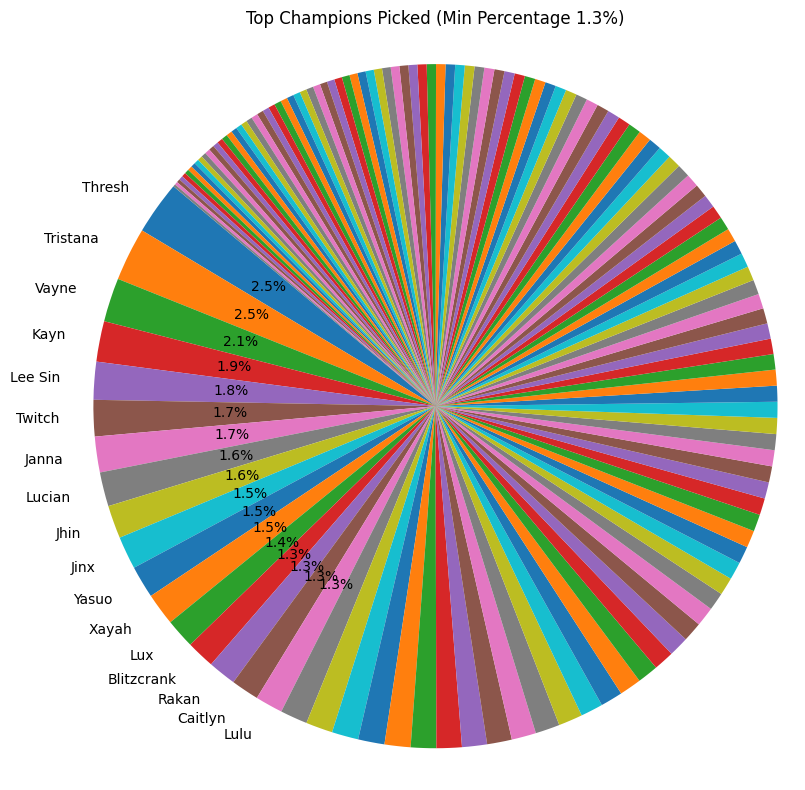

In [14]:
# Function to count occurrences and plot top champions with names using matplotlib pie chart
def plot_top_champions_pie(df, plot_title, champion_info, min_percentage=1.3):
    # Concatenate all champion IDs from both teams
    champ_cols = ['t1_champ1id', 't1_champ2id', 't1_champ3id', 't1_champ4id', 't1_champ5id', 
                  't2_champ1id', 't2_champ2id', 't2_champ3id', 't2_champ4id', 't2_champ5id']
    all_champs = pd.concat([df[col] for col in champ_cols], ignore_index=True)
    
    # Count occurrences of each champion ID
    champ_counts = all_champs.value_counts().sort_values(ascending=False)
    
    # Get top champions and their names
    total_picks = champ_counts.sum()
    champ_ids = champ_counts.index.astype(str)
    champ_freq = champ_counts.values / total_picks * 100
    
    # Plotting the champions with names using matplotlib pie chart
    plt.figure(figsize=(8, 8))
    patches, texts, autotexts = plt.pie(champ_freq, labels=None, startangle=140, autopct='%1.1f%%')
    plt.title(plot_title)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
    # Adding labels only for champions with frequency > min_percentage
    for i, (champ_id, freq) in enumerate(zip(champ_ids, champ_freq)):
        champ_name = champion_info['data'][champ_id]['name']
        if freq > min_percentage:
            texts[i].set_text(f'{champ_name}')
        else:
            texts[i].set_text('')
            autotexts[i].set_text('')  # Remove percentage text
            autotexts[i].set_color('white')  # Set text color to match background
    
    plt.tight_layout()
    plt.show()

# Example usage with your DataFrame and champion_info JSON
plot_top_champions_pie(df, 'Top Champions Picked (Min Percentage 1.3%)', champion_info)

As observed, the most frequently picked champions were Thresh and Tristana, with Vayne closely following. As the percentages decrease, they become increasingly similar, indicating that these champions are chosen at similar frequencies. However, it's important to note that certain champions are banned more frequently than others. Therefore, relying solely on pick rate from this plot may not provide a completely accurate measure.

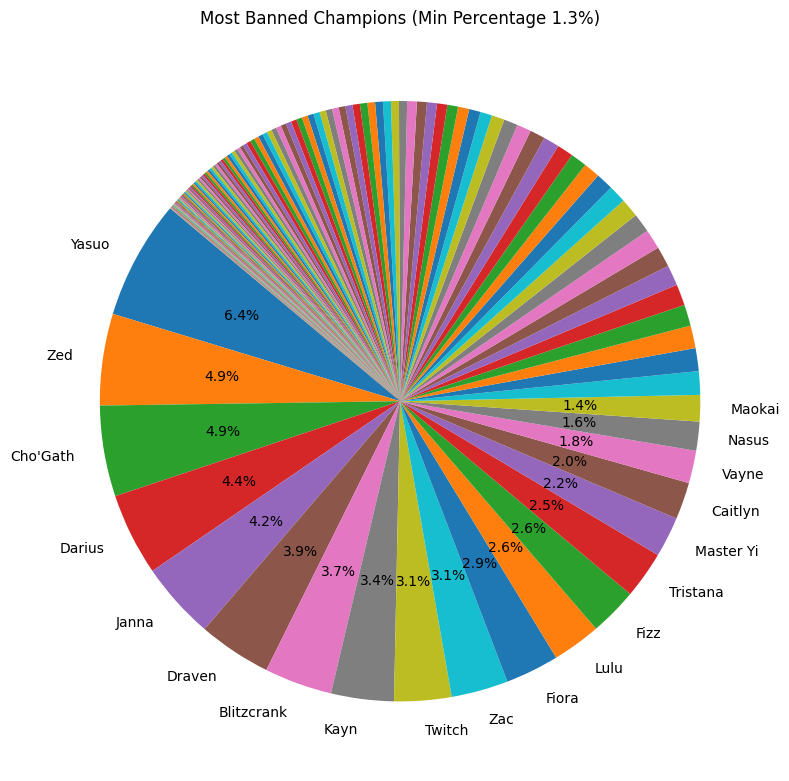

In [15]:
# Function to plot most banned champions with names using matplotlib pie chart
def plot_most_banned_champions_pie(df, plot_title, champion_info, min_percentage=1.3):
    # Concatenate all ban columns from both teams
    ban_cols = ['t1_ban1', 't1_ban2', 't1_ban3', 't1_ban4', 't1_ban5', 
                't2_ban1', 't2_ban2', 't2_ban3', 't2_ban4', 't2_ban5']
    all_bans = pd.concat([df[col] for col in ban_cols], ignore_index=True)
    
    # Count occurrences of each ban ID
    ban_counts = all_bans.value_counts().sort_values(ascending=False)
    
    # Get top banned champions and their names
    total_bans = ban_counts.sum()
    ban_ids = ban_counts.index.astype(str)
    ban_freq = ban_counts.values / total_bans * 100
    
    # Plotting the banned champions with names using matplotlib pie chart
    plt.figure(figsize=(8, 8))
    patches, texts, autotexts = plt.pie(ban_freq, labels=None, startangle=140, autopct='%1.1f%%')
    plt.title(plot_title)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
    # Adding labels only for banned champions with frequency > min_percentage
    for i, (ban_id, freq) in enumerate(zip(ban_ids, ban_freq)):
        if ban_id == '-1':  # Check if ban_id is '-1'
            texts[i].set_text('')
            autotexts[i].set_text('')
            autotexts[i].set_color('white')
            continue  # Skip to the next iteration
        
        champ_name = champion_info['data'][ban_id]['name']
        if freq > min_percentage:
            texts[i].set_text(f'{champ_name}')
        else:
            texts[i].set_text('')
            autotexts[i].set_text('')  # Remove percentage text
            autotexts[i].set_color('white')  # Set text color to match background
    
    plt.tight_layout()
    plt.show()

# Example usage with your DataFrame and champion_info JSON
plot_most_banned_champions_pie(df, 'Most Banned Champions (Min Percentage 1.3%)', champion_info)


Yasuo stands out as the most banned champion by a significant margin. This could be attributed to his high mobility and steep learning curve, allowing players to execute complex and impressive plays that draw attention. The more popular a champion becomes, the more players of varying skill levels may attempt to use them, which can lead to both skilled and less experienced players wanting to ban this champion. Similar trends can be observed with champions like Zed and Draven. Unlike the pick rate chart, where champions are more evenly distributed, the ban pie chart reveals a more concentrated focus. This indicates a widespread consensus among players on which champions are considered ban-worthy. Riot with this plot, can try to understand why this happens and why this same champions tend to be banned, this could be because the champions is overall overpowered in a given patch or simply annoying to play with or against. Despite high ban rates, champions such as Tristana, Twitch, Kayn, and Vayne continue to maintain high pick rates, indicating strong player demand for these champions.

# Champion win rates

In [16]:
# Example code to calculate win rates for champions
def calculate_win_rates(df):
    # Initialize dictionaries to store games played and wins for each champion
    champion_games = {}
    champion_wins = {}
    
    # Iterate through each row in the DataFrame
    for index, row in df.iterrows():
        # Determine the winning team and champions
        winning_team = int(row['winner'])
        team1_champions = [row[f't1_champ{i}id'] for i in range(1, 6)]
        team2_champions = [row[f't2_champ{i}id'] for i in range(1, 6)]
        
        # Update games played for each champion in team 1
        for champ_id in team1_champions:
            if champ_id not in champion_games:
                champion_games[champ_id] = 0
                champion_wins[champ_id] = 0
            champion_games[champ_id] += 1
            if winning_team == 1:
                champion_wins[champ_id] += 1
        
        # Update games played for each champion in team 2
        for champ_id in team2_champions:
            if champ_id not in champion_games:
                champion_games[champ_id] = 0
                champion_wins[champ_id] = 0
            champion_games[champ_id] += 1
            if winning_team == 2:
                champion_wins[champ_id] += 1
    
    # Calculate win rates for each champion
    champion_win_rates = {}
    for champ_id in champion_games:
        if champion_games[champ_id] > 0:
            win_rate = champion_wins[champ_id] / champion_games[champ_id]
            champion_win_rates[champ_id] = win_rate
    
    return champion_win_rates

# Calculate win rates for champions
champion_win_rates = calculate_win_rates(df)


Top 5 champions with highest win rates:
1. Champion 'Janna' (ID: 40): Win Rate = 55.53%
2. Champion 'Sona' (ID: 37): Win Rate = 54.19%
3. Champion 'Yorick' (ID: 83): Win Rate = 53.99%
4. Champion 'Rammus' (ID: 33): Win Rate = 53.85%
5. Champion 'Anivia' (ID: 34): Win Rate = 53.60%
6. Champion 'Singed' (ID: 27): Win Rate = 53.47%
7. Champion 'Swain' (ID: 50): Win Rate = 53.15%
8. Champion 'Sejuani' (ID: 113): Win Rate = 53.12%
9. Champion 'Garen' (ID: 86): Win Rate = 53.10%
10. Champion 'Shyvana' (ID: 102): Win Rate = 53.01%

Top 5 champions with lowest win rates:
1. Champion 'Ezreal' (ID: 81): Win Rate = 46.45%
2. Champion 'Nidalee' (ID: 76): Win Rate = 46.24%
3. Champion 'Lissandra' (ID: 127): Win Rate = 46.06%
4. Champion 'Tahm Kench' (ID: 223): Win Rate = 46.04%
5. Champion 'Lee Sin' (ID: 64): Win Rate = 45.90%
6. Champion 'Poppy' (ID: 78): Win Rate = 45.17%
7. Champion 'Karma' (ID: 43): Win Rate = 45.15%
8. Champion 'Azir' (ID: 268): Win Rate = 43.36%
9. Champion 'Ornn' (ID: 516): 

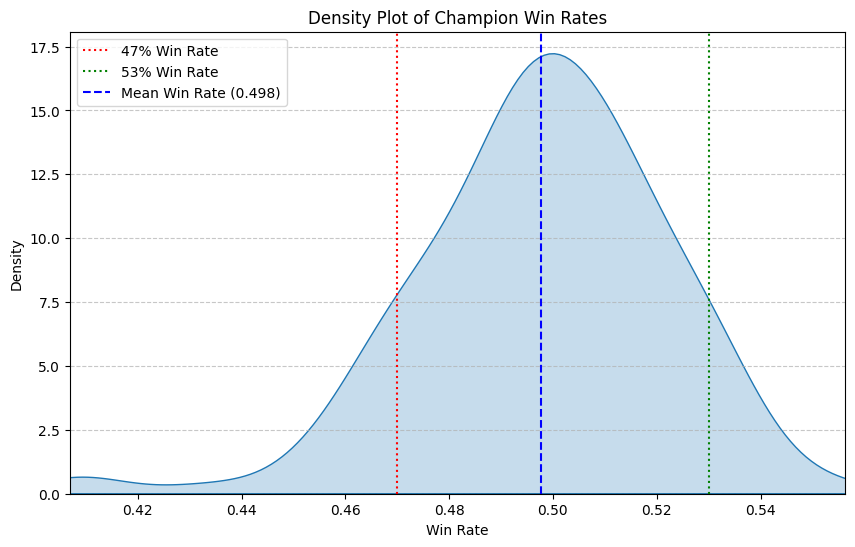

In [17]:
# Extract win rates into a list
win_rates = list(champion_win_rates.values())

# Get the min and max win rates
min_win_rate = min(win_rates) - 0.001
max_win_rate = max(win_rates) + 0.001

# Create a density plot using seaborn
plt.figure(figsize=(10, 6))
sns.kdeplot(win_rates, fill=True)
plt.title('Density Plot of Champion Win Rates')
plt.xlabel('Win Rate')
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add vertical lines for 45%, 55%, and mean
plt.axvline(0.47, linestyle='dotted', color='red', label='47% Win Rate')
plt.axvline(0.53, linestyle='dotted', color='green', label='53% Win Rate')

# Calculate and add a vertical line for the mean win rate
mean_win_rate = sum(win_rates) / len(win_rates)
plt.axvline(mean_win_rate, linestyle='dashed', color='blue', label=f'Mean Win Rate ({mean_win_rate:.3f})')

# Print top 5 champions with highest win rates
sorted_champions = sorted(champion_win_rates.items(), key=lambda x: x[1], reverse=True)
print("Top 5 champions with highest win rates:")
for i, (champ, win_rate) in enumerate(sorted_champions[:10], start=1):
    print(f"{i}. Champion '{champion_info['data'][champ]['name']}' (ID: {champ}): Win Rate = {win_rate:.2%}")

# Print top 5 champions with lowest win rates
print("\nTop 5 champions with lowest win rates:")
for i, (champ, win_rate) in enumerate(sorted_champions[-10:], start=1):
    print(f"{i}. Champion '{champion_info['data'][champ]['name']}' (ID: {champ}): Win Rate = {win_rate:.2%}")
    

# Set x-axis limits to show only the range of min and max win rates
plt.xlim(min_win_rate, max_win_rate)

plt.legend()  # Show legend with labels
plt.show()

With this plot, we can analyze the health of gameplay by assessing which champions are winning frequently and which are struggling. In an ideal scenario, all champions would ideally have win rates around 50%, indicating a balanced state where victories and losses are evenly distributed. For example, Ryze has a win rate of 40.79%, suggesting that out of every 10 games, Ryze players lose about 6. In contrast, Janna boasts a 55.53% win rate. Janna's high win rate reflects her strength, which likely contributes to her popularity among players, as seen on the champion picks plot.

Riot Games can use win rate data to identify champions in need of adjustments, whether by buffing those with low win rates or addressing balance issues among high-win-rate champions. However, win rates despite being a strong indicator of champion problems, they alone can't say for certain that is the truth.For example, new champions often start with lower win rates due to players' unfamiliarity and learning curve, which is natural as players adapt. This learning curve can also affect older champions with complex kits, where less skilled players might struggle more, resulting in lower win rates.



# Machine Learning

In [18]:
# Exclude the target variable 'Winner'
X = df.drop(columns=['winner'])

# Step 2: Define your target (y)
y = df['winner']

In [19]:
# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33333, random_state=42)

In [20]:
'''
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit on training data
scaler.fit(X_train)

# Transform training, validation, and test sets
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

'''
# Initialize StandardScaler
scaler = StandardScaler()

# Fit on training data
scaler.fit(X_train)

# Transform training, validation, and test sets
X_train_scaled = scaler.transform(X_train)
X_val_scaled  = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# Print the shape of each set
print(f"Training set shape: {X_train_scaled .shape}, {y_train.shape}")
print(f"Validation set shape: {X_val_scaled .shape}, {y_val.shape}")
print(f"Test set shape: {X_test_scaled .shape}, {y_test.shape}")

Training set shape: (36043, 57), (36043,)
Validation set shape: (10298, 57), (10298,)
Test set shape: (5149, 57), (5149,)


## Models

Accuracy on validation set: 0.963294
Classification Report:
              precision    recall  f1-score   support

           1       0.97      0.96      0.96      5234
           2       0.96      0.97      0.96      5064

    accuracy                           0.96     10298
   macro avg       0.96      0.96      0.96     10298
weighted avg       0.96      0.96      0.96     10298



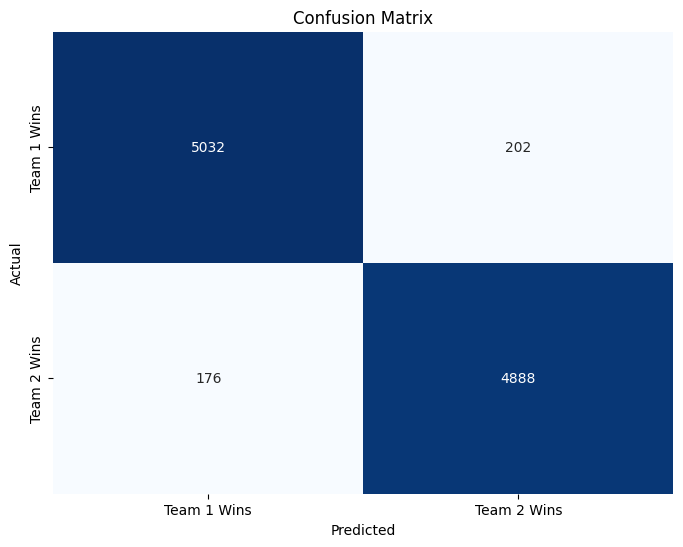

In [21]:
# Initialize the logistic regression model
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
logreg.fit(X_train_scaled, y_train)

# Predict on validation set
y_val_pred = logreg.predict(X_val_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print(f'Accuracy on validation set: {accuracy:.6f}')

# Classification report
print('Classification Report:')
print(classification_report(y_val, y_val_pred))

# Calculate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Plot confusion matrix with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False,
            xticklabels=['Team 1 Wins', 'Team 2 Wins'],
            yticklabels=['Team 1 Wins', 'Team 2 Wins'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/home/tomasoom/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Accuracy on validation set: 1.000000

Best model parameters found in GridSearchCV:
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5}

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      5234
           2       1.00      1.00      1.00      5064

    accuracy                           1.00     10298
   macro avg       1.00      1.00      1.00     10298
weighted avg       1.00      1.00      1.00     10298



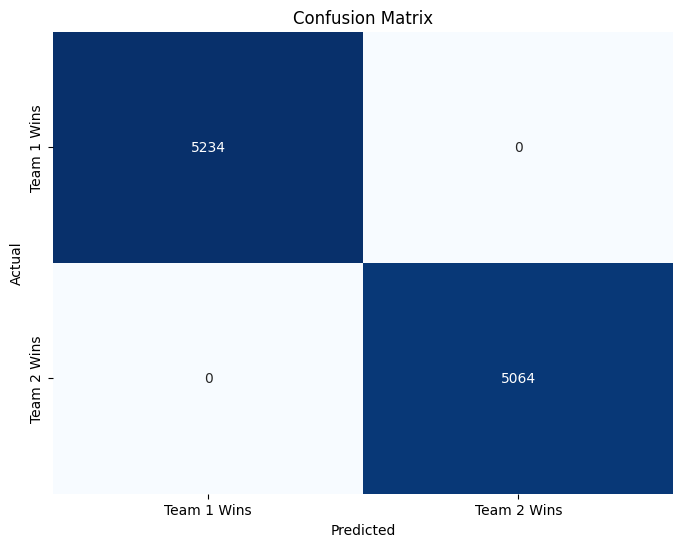

In [22]:
# Initialize the decision tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Get the best model
best_dt_model = grid_search.best_estimator_

# Predict on validation set
y_val_pred = best_dt_model.predict(X_val)

# Calculate performance metrics
accuracy = accuracy_score(y_val, y_val)
print(f'Accuracy on validation set: {accuracy:.6f}')

# Print best model parameters
print(f'\nBest model parameters found in GridSearchCV:')
print(grid_search.best_params_)

# Classification report
print('\nClassification Report:')
print(classification_report(y_val, y_val))

# Calculate confusion matrix
cm = confusion_matrix(y_val, y_val)

# Plot confusion matrix with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False,
            xticklabels=['Team 1 Wins', 'Team 2 Wins'],
            yticklabels=['Team 1 Wins', 'Team 2 Wins'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Permutation Feature Importance


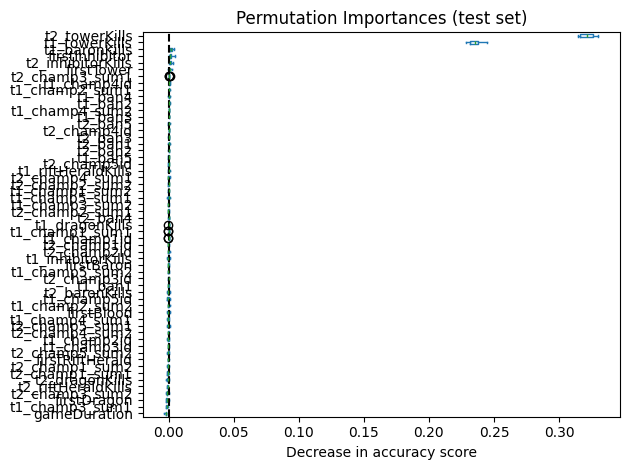

In [23]:
result = permutation_importance(
    logreg, X_test_scaled, y_test, n_repeats=10, random_state=42,
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

<Figure size 1000x800 with 0 Axes>

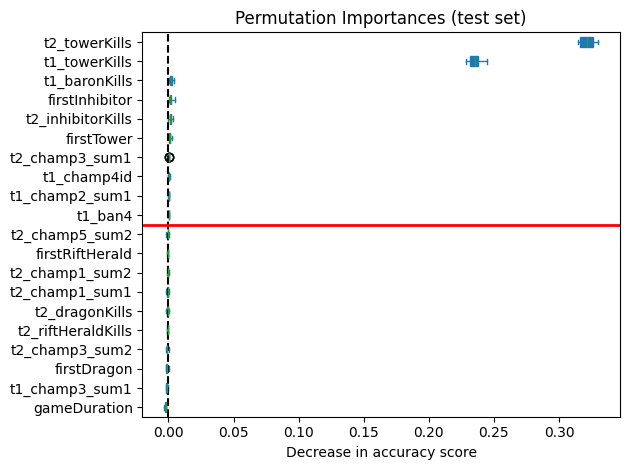

In [24]:
# Calculate permutation importance
result = permutation_importance(
    logreg, X_test_scaled, y_test, n_repeats=10, random_state=42,
)

# Sort importances
sorted_importances_idx = result.importances_mean.argsort()

# Select top and bottom 5 columns
selected_idx = list(sorted_importances_idx[:10]) + list(sorted_importances_idx[-10:])
selected_importances = result.importances[selected_idx]

# Create a DataFrame for the selected importances
importances = pd.DataFrame(
    selected_importances.T,
    columns=X.columns[selected_idx],
)

# Plot the boxplot
plt.figure(figsize=(10, 8))
ax = importances.plot.box(vert=False, whis=10, patch_artist=True)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")

# Add a horizontal line to separate top 5 and bottom 5 features
num_top_features = 9
num_total_features = len(selected_idx)
ax.axhline(y=num_total_features - num_top_features - 0.5, color='r', linestyle='-', linewidth=2)

ax.figure.tight_layout()
plt.show()

To determine which features contributed most to the model's predictions, permutation feature importance was used. This method involves shuffling the values of each feature to observe the change in model accuracy. If the accuracy decreases significantly when a feature's values are shuffled, it indicates that the feature is important for the model.

The plot above demonstrates that features like **tower kills, baron kills, first tower, and inhibitor kills** are extremely important, with **tower kills for each team being particularly significant**. Conversely, features such as **game duration, the first dragon and herald, and the number of dragon and herald kills are considered less important**. In some cases, shuffling these less important features even resulted in an increase in model accuracy.

# SHAP

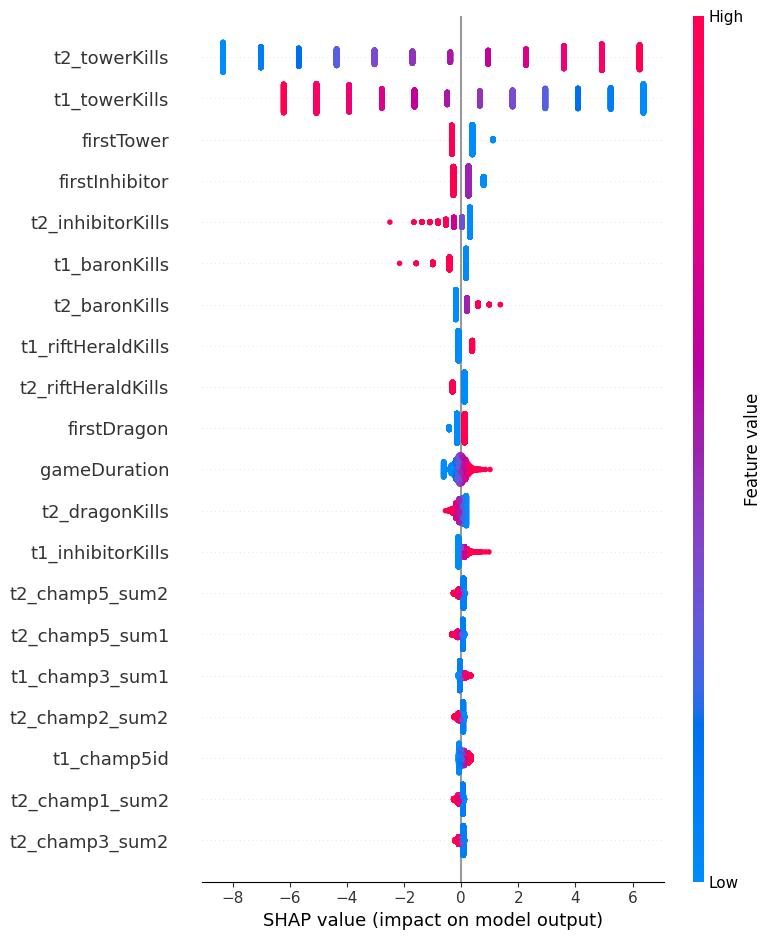

In [132]:
# Ensure the feature names are retained
feature_names = df.drop(columns=['winner']).columns

# Initialize and use the SHAP explainer with the actual feature names
explainer = shap.Explainer(logreg, X_train_scaled, feature_names=feature_names)

# Calculate SHAP values for the test set
shap_values = explainer(X_test_scaled)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names)


In both the permutation feature importance plot and the SHAP (SHapley Additive exPlanations) values analysis, features like "tower kills," "first tower," and "inhibitor kills" emerged as the most significant predictors. When using SHAP values for interpretability, lower values indicate contributions towards class 0 (indicating a win for team 1), while higher values indicate contributions towards class 1 (indicating a win for team 2).

To illustrate this, let's examine the top two features: `t2_towerKills` and `t1_towerKills`. For `t2_towerKills`, higher feature values (represented by a red color in the plot) correspond to higher SHAP values. This makes sense because the more towers team 2 destroys, the greater their chances of winning. Conversely, for `t1_towerKills`, higher feature values (also marked in red) lead to lower SHAP values. This indicates that as team 1 destroys more towers, the likelihood of team 1 winning increases, while the likelihood of team 2 winning decreases. 

**In summary, high values for team 2 tower kills boost team 2's chances, while high values for team 1 tower kills boost team 1's chances.**

Below there's an example for three games, that shows how much each feature contributed

# Game 1 (Complete Victory of Team 1)

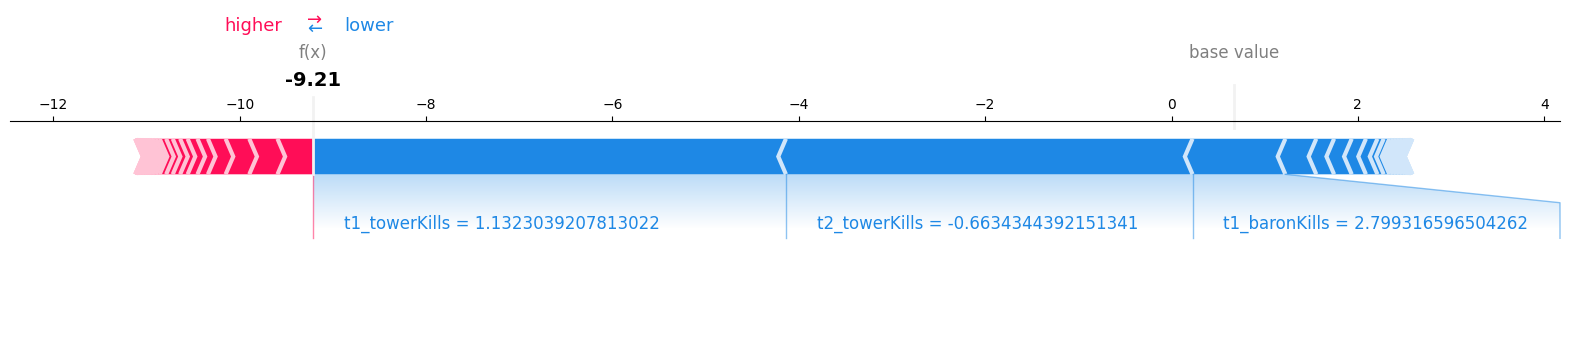

In [31]:
# Plot the SHAP values for a single prediction
# Example: for the first instance in the validation set
shap.force_plot(explainer.expected_value, shap_values.values[0], X_test_scaled[0], feature_names=feature_names, matplotlib=True)


**Important features mentioned:**
- **`t2_towerKills`:** 3
- **`t1_towerKills`:** 10
- **`t1_baronKills`:** 2
- **`winner`:** 1

**Base Value:**  
The base value, positioned around the 0 mark, represents the average model prediction when no specific feature values are considered.

**Final Prediction \( f(x) \):**  
The model's prediction for this instance is approximately \(-11.27\), shown at the center of the plot. This negative value suggests a stronger prediction towards one class, team 1.

**Feature Contributions:**  
- **`FirstTower`:** This feature has a negative SHAP value of approximately \(-0.83\), shown in red. It decreases the final prediction, pushing it towards class 0 (potentially indicating a win for team 1).
- **`t2_towerKills`:** With a significant negative SHAP value of approximately \(-1.44\), this feature strongly pushes the prediction towards a negative outcome, suggesting a lower likelihood of team 1 winning.
- **`t1_towerKills`:** This feature contributes positively, with a SHAP value of around \(0.87\), indicating that more tower kills by team 1 (9) are increasing the likelihood of a win for team 2.
- **`t1_baronKills`:** Also contributing positively, with a SHAP value of around \(1.08\), this feature suggests that more baron kills are associated with a higher likelihood of team 2 winning.

**Interpretation:**  
- **Negative SHAP values:** Features like `t2_towerKills` and `firstTower` decrease the model's prediction value, pushing it towards class 0 (potentially indicating a win for team 1).
- **Positive SHAP values:** Features like `t1_towerKills` and `baronKills` increase the model's prediction value, pushing it towards class 1 (potentially indicating a win for team 2).

**Conclusion:**  
The final prediction of \(-11.27\) suggests a strong influence from features with negative SHAP values, primarily `t2_towerKills` and `firstTower`. This outcome indicates that, for this instance, the model predicts an outcome favoring class 0, potentially a win for team 1. The force plot clearly shows how each feature supports or opposes the final prediction, providing insights into the model's decision-making process.

# Game 2 (Complete Victory of Team 2)



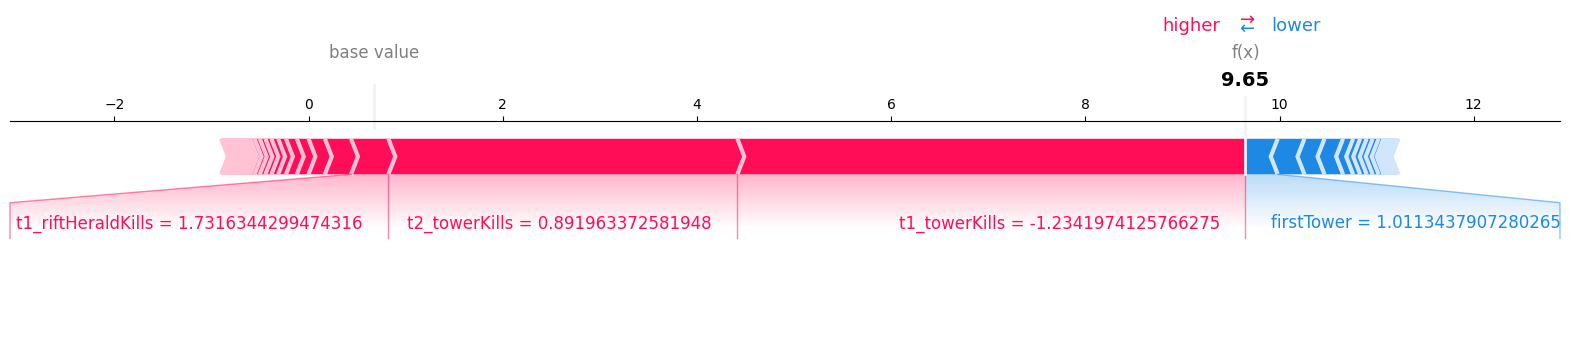

In [36]:
# Example: for the first instance in the validation set
shap.force_plot(explainer.expected_value, shap_values.values[1], X_test_scaled[1], feature_names=feature_names, matplotlib=True)         

**Important Features mentioned:**

- **`t1_towerKills:`** 1
- **`t2_towerKills:`** 9
- **`t1_riftHeraldKills:`** 1
- **`FirstTower:`** 2
- **`winner`:** 2
    
**Base Value:**  
The base value, positioned around the 0 mark, represents the average model prediction when no specific feature values are considered.

**Final Prediction \( f(x) \):**:
The model's prediction for this instance is approximately 9.65, as shown at the center of the plot. This positive value suggests a stronger prediction towards one class, potentially indicating an outcome favoring one of the teams, which is identified as Team 2 based on the features and SHAP values.

**Feature Contributions:**  
- **`t1_towerKills:`** Despite being a typically positive feature, here it has a negative SHAP value (around -1.23), indicating that fewer tower kills (1) by Team 1 reduce the likelihood of their win, thus favoring Team 2.

- **`t2_towerKills:`** Team 2 tower kills (9) is associated with a positive SHAP value (around 0.89), suggesting it contributes to a higher likelihood of Team 2 winning.

- **`t1_riftHeraldKills:`** This feature has a significant positive SHAP value (around 1.73), indicating that the Rift Herald kill by Team 1 pushed the prediction towards a positive outcome, potentially indicating a win for Team 2.

- **`FirstTower:`** The first tower kill is linked with a positive SHAP value (around 1.01), showing it as a significant factor contributing to the positive prediction towards Team 2's victory.

- **`Winner Prediction:`**
The final prediction of 9.65 indicates a strong leaning towards Team 2 as the winner. The positive SHAP contributions, particularly from t1_riftHeraldKills and FirstTower, significantly influence this outcome.

**Interpretation:**
- **Positive SHAP values:** The significant positive contributions from `t1_riftHeraldKills`, `t2_towerKills`, and `FirstTower` increase the model's prediction value, indicating a strong likelihood of a win for Team 2.

- **Negative SHAP values:** The negative contribution from `t1_towerKills` suggests that the model slightly accounts for fewer tower kills by Team 1, but this is not enough to offset the strong positive influences.

**Conclusion:**
The model's final prediction of 9.65, along with the SHAP values, indicates a clear prediction favoring Team 2 as the winner. The positive contributions from features like `t1_riftHeraldKills` and `t2_towerKills` significantly drive this prediction, outweighing any negative impact from the other features. The SHAP force plot effectively shows how each feature influences the final prediction, providing clear insights into the model's reasoning for this specific game instance.

# Game 3 (Very competitive game)

In [127]:
# Example: for the first instance in the validation set
shap.force_plot(explainer.expected_value, shap_values.values[5], X_test_scaled[5], feature_names=feature_names)

**Important Features Mentioned:**

- **`gameDuration:`** 2302 seconds
- **`t1_riftHeraldKills:`** 1
- **`firstTower:`** 1
- **`t2_baronKills:`** 2
- **`t2_towerKills:`** 8
- **`t1_towerKills:`** 7
- **`t1_baronKills:`** 1
- **`firstInhibitor:`** 2
- **`firstDragon:`** 1
- **`winner:`** 1 (Team 1)

**Base Value:**  
The base value represents the average model prediction when no specific feature values are considered, positioned around the 0 mark.

**Final Prediction \( f(x) \):**  
The model's prediction for this instance is approximately 1.87. Since the prediction is a positive value, it suggests that the model favors Team 2 to win based on the features and SHAP values.

**Feature Contributions:**

- **`gameDuration:`** The SHAP value of 0.9174 indicates a positive contribution from a game duration of 2302 seconds. Longer games tend to favor the team that performs well in the later stages, which benefits Team 2 in this case.

- **`t1_riftHeraldKills:`** The SHAP value of 1.732 for Team 1’s Rift Herald kill (1) suggests a positive impact, contributing towards Team 2’s likelihood of winning. This indicates that while beneficial, the Rift Herald kill's impact is outweighed by other features favoring Team 2.

- **`firstTower:`** The SHAP value of -0.8304 shows a negative contribution from Team 1’s first tower kill, suggesting that securing the first tower benefitted them.

- **`t2_baronKills:`** The SHAP value of 2.587 indicates a strong positive contribution from Team 2’s Baron kills (2). This feature significantly boosts the prediction for Team 2, highlighting the importance of this objective for their victory.

- **`t2_towerKills:`** With a SHAP value of 0.6327, Team 2’s 8 tower kills positively contribute to the prediction. More tower kills generally strengthen Team 2’s position, favoring their chances of winning.

- **`t1_towerKills:`** The SHAP value of 0.3435 for Team 1’s 7 tower kills indicates a small positive contribution. This suggests that Team 1’s number of tower kills actually favors Team 2’s chances of winning. This counterintuitive result may be due to the fact that in many games, a team that destroys fewer towers (even if they have more kills) often ends up losing, thereby improving the odds for Team 2.

- **`t1_baronKills:`** The SHAP value of 1.081 for Team 1’s Baron kill (1) indicates a positive contribution. Despite the fact that securing the Baron is typically a significant advantage for a team, the positive SHAP value here suggests that this feature actually favors Team 2’s chances of winning. This is likely because Team 1’s fewer Baron kills compared to Team 2 may diminish their overall advantage, thus improving Team 2's predicted chances of victory.

- **`firstInhibitor:`** The SHAP value of 1.022 reflects a positive contribution from securing the first inhibitor (2). This milestone generally benefits the team achieving it, thus favoring Team 2’s prediction.

- **`firstDragon:`** With a SHAP value of -0.7823, Team 1’s first dragon kill (1) has a negative contribution. This suggests that securing the first dragon benefits Team 1, but the effect is not as strong as features.

**Interpretation:**

- **Positive SHAP Values:** Features such as `t2_baronKills`, `t2_towerKills`, `t1_riftHeraldKills`, and `firstInhibitor` have significant positive contributions, driving the model’s prediction towards Team 2’s victory.

- **Negative SHAP Values:** The negative contributions from `firstTower` and `firstDragon` suggest that these features actually help Team 1’s chances of winning, despite their typical advantage for Team 2.

**Conclusion:**

The final prediction of 1.87, supported by the SHAP values, suggests a favorable outcome for Team 2. The significant positive contributions from features like `t2_baronKills`, `t1_riftHeraldKills`, and `t2_towerKills` indicate that Team 2 was more likely to win according to the model. The SHAP values offer clear insights into how each feature impacts the prediction, underscoring the factors that contribute to Team 2's projected victory.

However, despite this prediction, Team 1 emerged as the actual winner of the game. Analyzing the feature contributions reveals potential reasons for this discrepancy. Although Team 2 secured more objectives such as towers and Barons, they ultimately lost, possibly due to critical late-game mistakes or superior scaling of Team 1's champions. This insight highlights the complexity of game outcomes, where individual objectives and their contributions may not always align with the final result.
